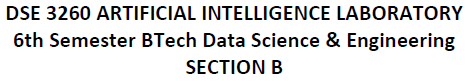

## Kartabya Krishna
## RegNo: 210968244
## Week: 6
## Date: 20240219

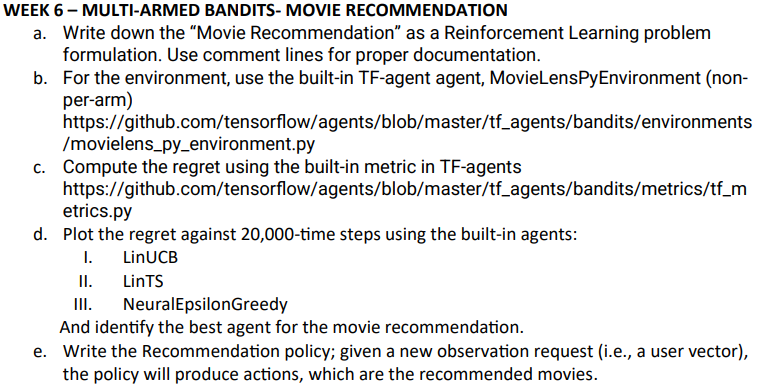

# Problem Formulation
Problem Formulation:

- **`State`**: The state of the system can be defined as the user's historical movie watching behavior, preferences, and any other relevant information such as age, gender, etc.

- **`Action`**: The action space consists of the recommended movies that the user can choose to watch.

- **`Reward`**: The reward function can be designed to optimize the user's satisfaction with the recommended movies. For example, the reward function can be based on the user's rating of the recommended movie, where a higher rating results in a higher reward. Alternatively, the reward function can be designed to maximize the user's engagement or diversity of the recommended movies.

- **`Environment`**: The environment consists of the movie recommendation system that takes the user's state and action as input and generates a recommendation as output.

- **`Policy`**: The policy defines the movie recommendation algorithm used to suggest the next movie for the user. The goal is to optimize the policy to maximize the cumulative reward over time.

The objective of the reinforcement learning algorithm in this context is to learn the optimal policy that recommends movies to the user, taking into account the user's preferences and historical behavior. The algorithm should aim to maximize the user's satisfaction or engagement with the recommended movies over time.

### Importing libraries and setting up tensorflow agents

In [70]:
import tensorflow as tf
import distutils
!pip install tf_agents
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Fix TensorFlow version check
tf_version = tf.__version__
if distutils.version.LooseVersion(tf_version) < distutils.version.LooseVersion("2.2.0"):
    raise ImportError(
        "This version of TF Agents requires TensorFlow "
        "version >= 2.2.0; Detected an installation of version {present}. "
        "Please upgrade TensorFlow to proceed.".format(present=tf_version)
    )


import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## MovieLens 100K Dataset - u.data
The u.data file is part of the [MovieLens 100K Dataset](https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset/data), containing 100,000 ratings provided by 943 users for 1,682 movies. The dataset is commonly used for collaborative filtering and recommendation system tasks.

### Dataset Overview:
- **File Name:** u.data
- **Size:** 100,000 ratings
- **Users:** 943
- **Movies:** 1,682
- **Minimum Ratings per User:** 20

### Columns:
1. **UserID:** Unique identifier for each user.
2. **MovieID:** Unique identifier for each movie.
3. **Rating:** User-provided rating for the movie (scale may vary, e.g., 1 to 5 stars).
4. **Timestamp:** Unix timestamp indicating when the rating was provided (seconds since 1/1/1970 UTC).

### Dataset Description:
- Users and items (movies) are consecutively numbered from 1.
- Each user has rated at least 20 movies, ensuring a substantial amount of data for analysis.
- The data is randomly ordered, providing a diverse and unbiased representation.

### Usage:
The u.data dataset is typically utilized for tasks such as collaborative filtering, matrix factorization, and recommendation system development. The ratings and user-item interactions captured in this dataset offer valuable insights into user preferences and movie popularity.

### Example Tuple Explanation:

Consider the example tuple from the u.data file:

```plaintext
186      302      3      891717742
```

This tuple represents a single user's rating for a specific movie. Breaking down each component:

1. **UserID (186):** The unique identifier for the user who provided the rating. In this case, UserID 1.

2. **MovieID (302):** The unique identifier for the movie being rated. In this example, MovieID 186.

3. **Rating (3):** The user-provided rating for the movie on a scale that may vary (e.g., 1 to 5 stars). Here, the user gave a rating of 3.

4. **Timestamp (891717742):** The Unix timestamp indicating when the rating was provided. In this case, the rating was given at a time corresponding to 891717742 seconds since 1/1/1970 UTC.

So, in this example, User 186 rated Movie 302 with a score of 3 at a specific timestamp. This format repeats for each entry in the dataset, capturing the user-movie interactions and ratings across the entire MovieLens 100K Dataset.

In [71]:
# Specify the column names
column_names = ['UserID', 'MovieID', 'Rating', 'Timestamp']
# Read the u.data file into a DataFrame
df = pd.read_csv('./input/u.data', sep='\t', names=column_names)
df.head()

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [72]:
BATCH_SIZE = 10
TRAINING_LOOPS = 2000 #set to 2000 instead of 20000. So, as to avoid crashing.
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20

## Hyperparameters Initialization

The code initializes hyperparameters that will be used in subsequent operations related to the MovieLens dataset and reinforcement learning training.

### Hyperparameter Values:

1. **BATCH_SIZE:**
   - Represents the number of data points (user-movie interactions) processed in each training batch. A smaller batch size is often chosen for efficient training.
2. **TRAINING_LOOPS:**
   - Specifies the number of training loops or epochs. One training loop involves iterating through the entire dataset once during training.
3. **STEPS_PER_LOOP:**
   - Defines the number of steps (iterations) to be taken within each training loop. Controlling this value allows for more fine-grained control over the training process.
4. **RANK_K:**
   - Refers to the rank parameter used in matrix factorization for collaborative filtering. It determines the number of latent factors used to represent users and items. A higher rank may capture more complex relationships but could lead to overfitting.
5. **NUM_ACTIONS:**
   - Denotes the number of actions or items in the recommendation system. In this context, it may represent the number of movies being recommended to users.
### Overall Purpose:
- These hyperparameters are crucial for configuring the training process of reinforcement learning models, particularly in the context of collaborative filtering and recommendation systems using matrix factorization. They influence the batch processing, training duration, and the complexity of the model.
### Important Note:
- Adjusting hyperparameter values can significantly impact the performance and efficiency of the recommendation system. Fine-tuning these values is often necessary to achieve optimal results.

In [73]:
data_path = './input/u.data'

### Data Path:
- **data_path ('./input/u.data'):**
  - Specifies the path to the MovieLens dataset file ('u.data'). This dataset contains user ratings for movies and is structured with columns like UserID, MovieID, Rating, and Timestamp.

### Next, we set up the MovieLensPyEnvironment usign the above hyperparameters and wrap it in a TensorFlow environment.

In [74]:
# setting up the MovieLensPyEnvironment
env = movielens_py_environment.MovieLensPyEnvironment(
        data_path,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

## Next, we declare two partial functions that use the Movielens environment to compute the optimal reward and optimal action for the given state.


In [75]:
optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)

### Partial Function for Optimal Reward (optimal_reward_fn):

The `optimal_reward_fn` is a partial function crafted to calculate the optimal reward for a given state within the Movielens environment. Using the `functools.partial` method, a new function is created based on `environment_utilities.compute_optimal_reward_with_movielens_environment`. The fixed argument `environment` ensures consistent evaluation across various states.

**Purpose and Usage:**
This partial function proves invaluable for evaluating the performance of a Reinforcement Learning model. It facilitates the assessment of optimal rewards during the training or evaluation phases, providing insights into the model's ability to generate optimal rewards in the Movielens environment.

**How it Works:**
The `optimal_reward_fn` encapsulates the logic for computing optimal rewards. Leveraging the base function `compute_optimal_reward_with_movielens_environment`, this partial function maintains flexibility and reusability. By fixing the `environment` argument, it establishes a constant reference to the Movielens environment. This ensures seamless evaluation of optimal rewards across different states, contributing to the model's overall assessment.


In [76]:
# partial function to evaluate action function with optimal action
optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)

### Partial Function for Optimal Action Function (optimal_action_fn):

The `optimal_action_fn` serves as a partial function designed to compute the optimal action (i.e., recommended movie) for a given state within the Movielens environment. Similar to `optimal_reward_fn`, this function is created using the `functools.partial` method, utilizing the base function `environment_utilities.compute_optimal_action_with_movielens_environment`. The fixed argument `environment` ensures consistent evaluation across different states.

**Purpose and Usage:**

The primary purpose of `optimal_action_fn` is to facilitate the calculation of optimal actions within the Movielens environment. As a partial function, it proves valuable for assessing the performance of a Reinforcement Learning model during training or evaluation, providing insights into the model's ability to recommend optimal movies.

**How it Works:**

Similar to `optimal_reward_fn`, the `optimal_action_fn` encapsulates the logic for computing optimal actions. By leveraging the base function `compute_optimal_action_with_movielens_environment` and fixing the `environment` argument, this partial function ensures a consistent reference to the Movielens environment. It can be seamlessly utilized to determine the optimal action (recommended movie) for any given state within the Movielens environment.


These two partial functions are useful for evaluating the performance of a recommendation model trained using Reinforcement Learning. By comparing the rewards and actions produced by the model with the optimal values computed by these functions, we can determine how well the model is performing and whether it is learning to make good recommendations.

# -----------------------------------------------------------------------------------

### Next, we create an instance of the **`LinearUCBAgent`** class, which implements the LinUCB algorithm for contextual bandit problems.

In [77]:
AGENT_ALPHA = 10.0
linucb = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)

## Linear Upper Confidence Bound Agent Configuration

The LinUCB agent is configured with the following parameters:

- **`time_step_spec`**: Specifies the format of the input data that the agent receives from the environment at each time step. It includes the observation, reward, and discount, among other things.

- **`action_spec`**: Specifies the format of the actions that the agent can choose from. In this case, the agent can select one of the movies to recommend from the set of available actions.

- **`tikhonov_weight`**: A regularization hyperparameter controlling the weight given to the L2 regularization term in the linear regression used by the LinUCB algorithm. It helps prevent overfitting, and in this instance, the Tikhonov weight is set to 0.001.

- **`alpha`**: The exploration hyperparameter determining the tradeoff between exploration and exploitation in the LinUCB algorithm. The alpha value is set to the `AGENT_ALPHA` hyperparameter, which is 10.0 in this case. Higher values make the agent more exploratory, especially beneficial during the learning phase.

- **`dtype`**: Specifies the data type of the variables used in linear regression. In this case, `tf.float32` is used.

- **`accepts_per_arm_features`**: Specifies whether the agent expects to receive per-arm features as input. It is set to `False`, indicating that the agent does not use per-arm features. Per-arm features provide additional information about each available action (movies) and can enhance recommendation quality.

# -----------------------------------------------------------------------------------

### Next, we create an instance of the **`LinearThompsonSamplingAgent`** class, which implements the linear Thompson sampling algorithm for contextual bandit problems. This algorithm is similar to the LinUCB algorithm but uses a Bayesian approach to sample from the posterior distribution over the model parameters.

In [78]:
lints = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)

## Linear Thompson Sampling Agent Configuration

The Linear Thompson Sampling (LinTS) agent is configured with the following parameters:

- **`time_step_spec`**: Specifies the format of the input data that the agent receives from the environment at each time step. It includes the observation, reward, and discount, among other things.

- **`action_spec`**: Specifies the format of the actions that the agent can choose from. In this case, the agent can select one of the movies to recommend from the set of available actions.

- **`dtype`**: Specifies the data type of the variables used in linear regression. In this instance, `tf.float32` is used.

- **`accepts_per_arm_features`**: Specifies whether the agent expects to receive per-arm features as input. It is set to `False`, indicating that the agent does not use per-arm features. Per-arm features provide additional information about each of the available actions (movies) and can be valuable for enhancing the quality of recommendations.


# -----------------------------------------------------------------------------------

### Next, we create an instance of the **`NeuralEpsilonGreedyAgent`** class, which implements the epsilon-greedy algorithm using a neural network as the Q-function approximator. 

## Neural Epsilon Greedy Agent Configuration

### Now, we initialize the following hyperparameters:

- **`EPSILON`**: This is the probability of the agent choosing a random action instead of the greedy action (the action with the highest estimated reward). It controls the level of exploration versus exploitation in the agent's decision-making process.

- **`LAYERS`**: This is a tuple that specifies the number of hidden layers and the number of units in each layer of the Q-network used by the agent to estimate the rewards of different actions.

- **`LR`**: This is the learning rate used by the optimizer to update the Q-network parameters during training.

In [79]:
EPSILON = 0.05
LAYERS = (50, 50, 50)
LR = 0.005

### We use the above hyperparamters for the following:
- **`Network`**: This is an instance of the QNetwork class, which defines the architecture of the Q-network used by the agent to estimate the rewards of different actions based on the observed states.

- **`NeuralEpsilonGreedyAgent`**: This is an instance of the NeuralEpsilonGreedyAgent class, which implements the epsilon-greedy algorithm using a neural network as the Q-function approximator.
  
- **`time_step_spec`**: This parameter specifies the format of the input data that the agent receives from the environment at each time step. It includes the observation, reward, and discount, among other things.

- **`action_spec`**: This parameter specifies the format of the actions that the agent can choose from. In this case, the agent can select one of the movies to recommend from the set of available actions.

- **`reward_network`**: This parameter specifies the Q-network used by the agent to estimate the rewards of different actions based on the observed states.

- **`optimizer`**: This parameter specifies the optimizer used to update the Q-network parameters during training. In this case, the Adam optimizer is used with a learning rate of LR.

- **`emit_policy_info`**: This parameter specifies what policy information should be included in the data emitted by the agent during training. In this case, it includes the mean of the predicted rewards.

- **`info_fields_to_inherit_from_greedy`**: This parameter specifies what policy information should be inherited from the greedy policy. In this case, it includes the mean of the predicted rewards.


In [80]:
network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)

neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])

# -----------------------------------------------------------------------------------

### Now, we need to define the following metrics :

- **`RegretMetric`**: This is a metric that measures the difference between the total reward obtained by the bandit agent and the total reward that would have been obtained by always choosing the optimal action at each time step. It computes the cumulative regret over the course of the training process.
- **`SuboptimalArmsMetric`**: This is a metric that measures the proportion of time steps where the agent chooses a suboptimal action (an action other than the optimal action). It is a useful metric for evaluating the level of exploration versus exploitation in the agent's decision-making process.

In [81]:
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

### Now we define the following definition to train the agents :

In [82]:
def train(agent):

  if agent == 'LinUCB':
    agent = linucb
  elif agent == 'LinTS':
    agent = lints
  elif agent == 'NeurEps':
    agent = neureps


  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP)

  observers = [replay_buffer.add_batch, regret_metric]

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=STEPS_PER_LOOP * BATCH_SIZE,
      observers=observers)

  regret_values = []

  for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

  return regret_values, agent

The `train` function is designed to train a given reinforcement learning agent on the specified environment. The function takes an agent name as a parameter and configures the corresponding agent based on the provided name.

**Agent Configuration:**

- The function first checks the provided agent name and sets the agent accordingly. Options include 'LinUCB', 'LinTS', and 'NeurEps'. The chosen agent is then assigned to the `agent` variable.

**Replay Buffer and Observers:**

- A replay buffer is initialized using `tf_uniform_replay_buffer.TFUniformReplayBuffer`. This buffer is responsible for storing and managing the agent's experiences during training.
  
- Observers, including the replay buffer and the regret metric, are defined. Observers are entities that receive information during the training process.

**Driver Configuration:**

- The dynamic step driver (`dynamic_step_driver.DynamicStepDriver`) is set up to execute steps in the environment using the agent's collect policy. The number of steps is determined by the product of `STEPS_PER_LOOP` and `BATCH_SIZE`. Observers are specified to gather experiences into the replay buffer and track regret metrics.

**Training Loop:**

- The function then enters a training loop (`for _ in range(TRAINING_LOOPS)`) where the driver is run, and the agent is trained using the experiences stored in the replay buffer. After each training iteration, the replay buffer is cleared, and the regret metric values are recorded.

**Output:**

- The function returns a list of regret values and the trained agent. This list can be used to analyze the performance of the agent during training.


# -----------------------------------------------------------------------------------

### Now that we have all the necessary definitions declared, we can proceed with the training process

# `LinearUCBAgent`

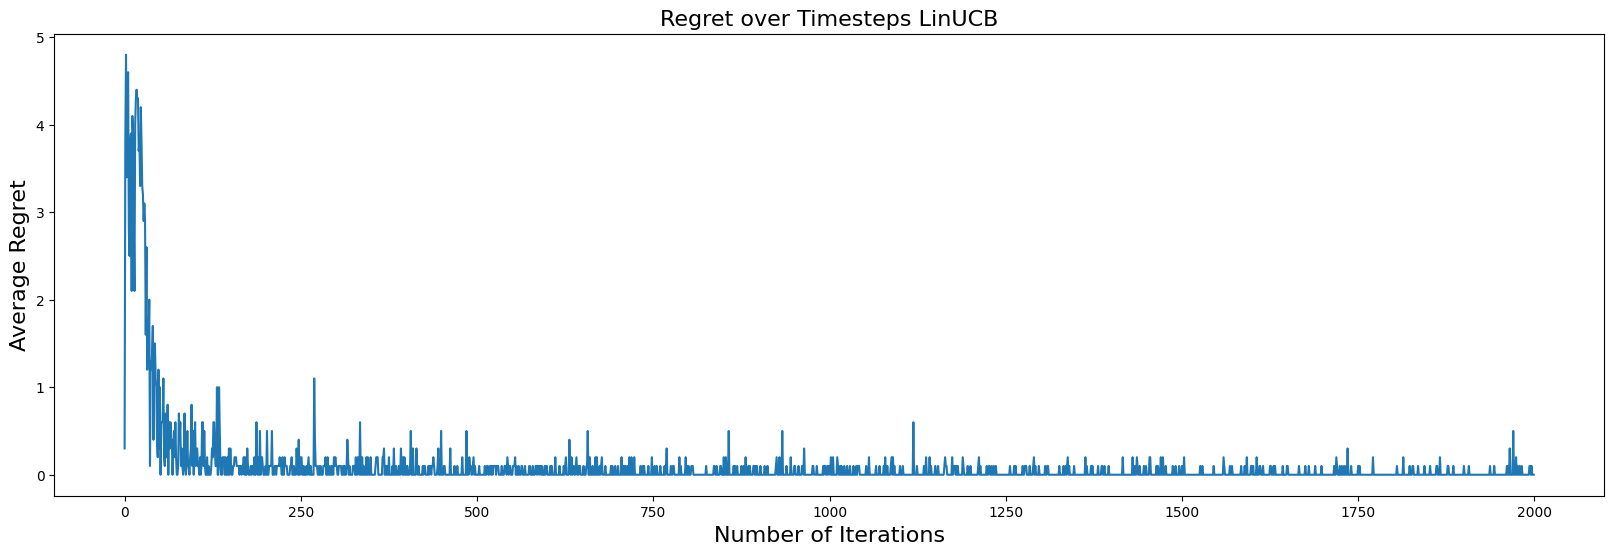

In [118]:
# plotting the regret values of the LinUCB agent
regret_values_linucb, linucb_agent = train('LinUCB')
plt.plot(regret_values_linucb)
plt.title('Regret over Timesteps LinUCB', fontsize=16)
plt.xlabel('Number of Iterations', fontsize=16)
plt.ylabel('Average Regret', fontsize=16)
fig = plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

In [84]:
# summation of regret values
print("We can see, the regret decreases over time. The cummulative regret for LinUCB is ", sum(regret_values_linucb))

We can see, the regret decreases over time. The cummulative regret for LinUCB is  tf.Tensor(224.30217, shape=(), dtype=float32)


# `LinearThompsonSamplingAgent`

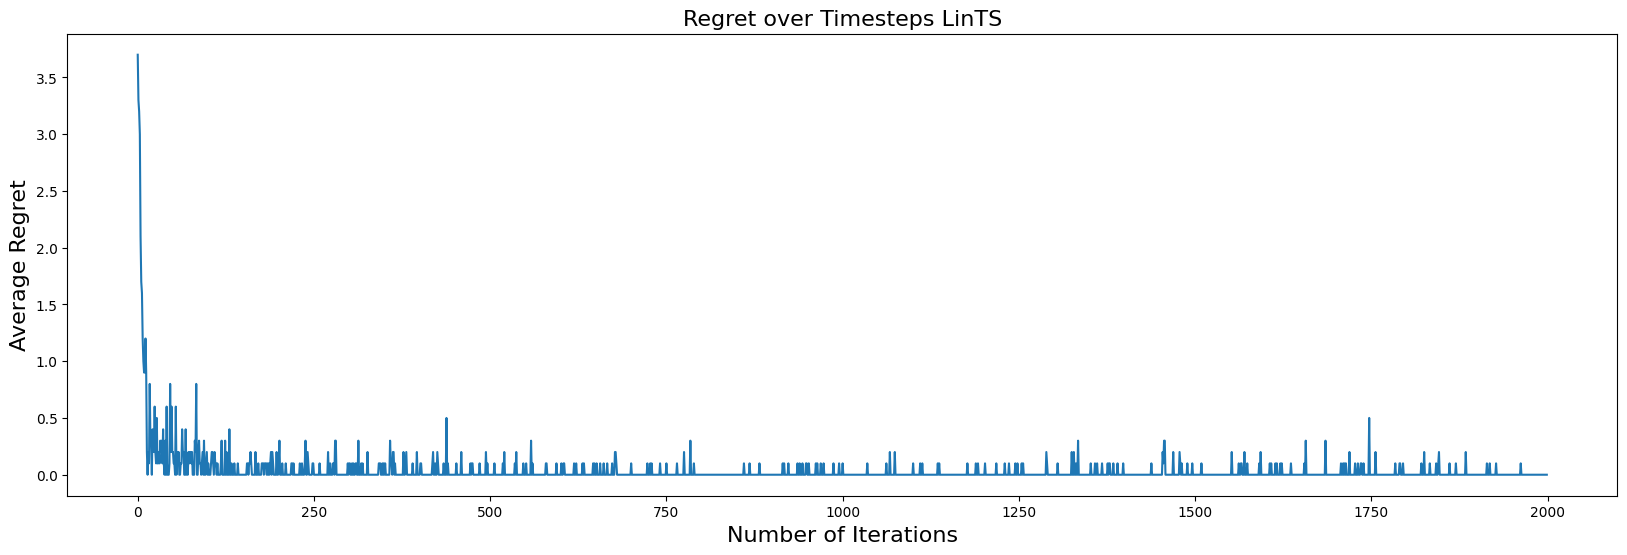

In [117]:
# plotting the regret values of the LinTS agent
regret_values_lints, lints_agent = train('LinTS')
plt.plot(regret_values_lints)
plt.title('Regret over Timesteps LinTS', fontsize=16)
plt.xlabel('Number of Iterations', fontsize=16)
plt.ylabel('Average Regret', fontsize=16)
fig = plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

In [86]:
# summation of regret values
print("We can see, the regret decreases over time. The cummulative regret for LinTS is ", sum(regret_values_lints))

We can see, the regret decreases over time. The cummulative regret for LinTS is  tf.Tensor(74.799675, shape=(), dtype=float32)


# `NeuralEpsilonGreedyAgent`

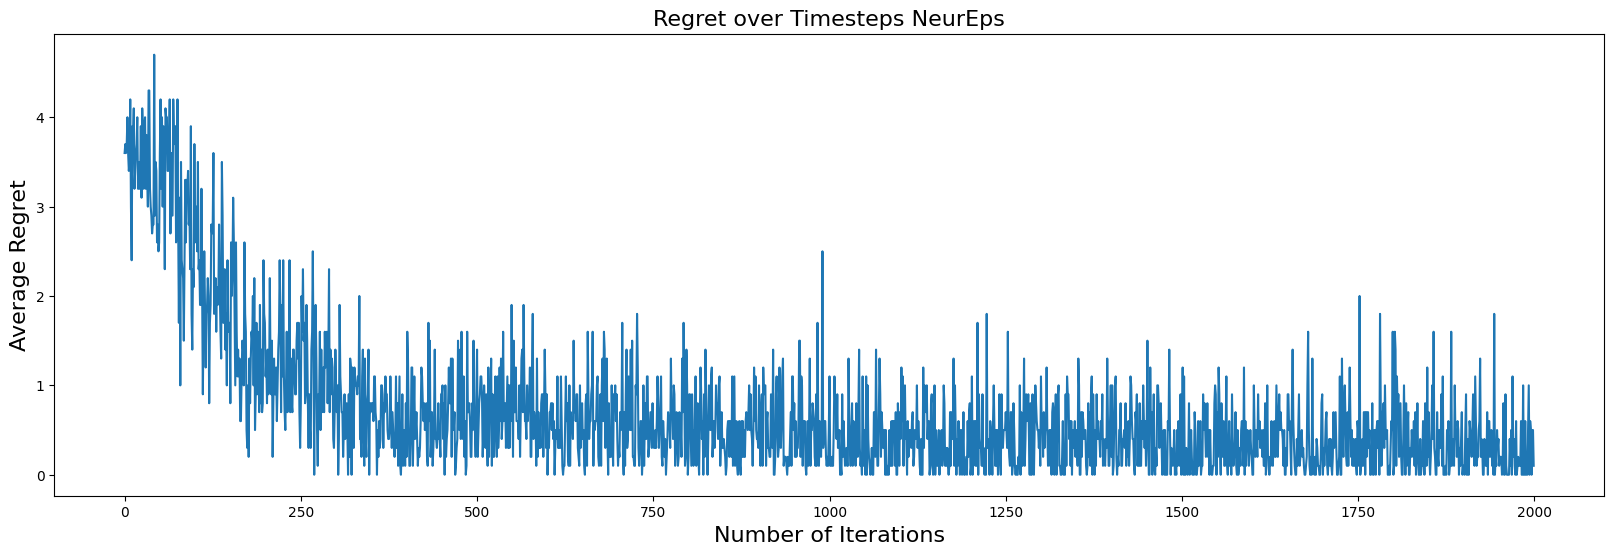

In [116]:
# plotting the regret values of the NeurEps agent
regret_values_neureps, neureps_agent = train('NeurEps')
plt.plot(regret_values_neureps)
plt.title('Regret over Timesteps NeurEps', fontsize=16)
plt.xlabel('Number of Iterations', fontsize=16)
plt.ylabel('Average Regret', fontsize=16)
fig = plt.gcf()
fig.set_size_inches(20, 6)
plt.show()

In [88]:
# summation of regret values
print("We can see, the regret decreases over time. The cummulative regret for NeurEps is ", sum(regret_values_neureps))

We can see, the regret decreases over time. The cummulative regret for NeurEps is  tf.Tensor(1438.0928, shape=(), dtype=float32)


# From the values of the cummulative regret, we can infer that the **best agent is LinTS as it has the least cummulative regret**.

# -----------------------------------------------------------------------------------

#### Now, we develop a recommendation policy designed to generate movie recommendations when provided with a new observation request, represented as a user vector. Initially, the policy constructs a TimeStep object, encapsulating the current time step within the RL environment. This object includes the provided observation along with preset values for the step type, reward, and discount.
#### Subsequently, the policy leverages the agent's policy to choose an action corresponding to the given time step. The action method of the policy yields an ActionStep object containing the recommended action.
#### In conclusion, the function outputs the recommended action in the form of a NumPy array. The [0] index is utilized to extract the scalar value from the one-element NumPy array.

In [141]:
# recommendation policy
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)
    
    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

## `To test out the policy, we input a random observation vector and get the recommended movie id in return. We use the LinTS agent to check it out, as the it was best performer as per our analysis.`

In [142]:
# testing out the policy
observation = np.array([1, 36, 28, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1])
observation = np.expand_dims(observation, axis=0)
mov = recommend_movies(lints_agent, observation=observation)

#### The code below, reads a movie dataset (u.item) into a Pandas DataFrame, and then defines a function (recommend_movies) to recommend movies based on a given movie index. The function looks up the movie title in the DataFrame and prints the recommended movie title. If the movie index is not found, it prints a message indicating that the movie was not found for the given index.

In [143]:
import pandas as pd

# Assuming you have a u.item file with columns specified in your description
columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL",
           "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
           "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
           "Romance", "Sci-Fi", "Thriller", "War", "Western"]

# Read the u.item file into a DataFrame with the specified encoding
df_movies = pd.read_csv('./input/u.item', sep='|', encoding='latin-1', header=None, names=columns)

def recommend_movies(movie_index):
    try:
        # Get the movie title based on the passed movie index
        recommended_movie_title = df_movies.loc[df_movies['movie_id'] == movie_index, 'movie_title'].values[0]
        
        # Print the recommended movie title
        print("Recommended Movie:", recommended_movie_title)
        return recommended_movie_title
    except IndexError:
        print("Movie not found for the given index.")
        return None

# Example usage
recommend_movies(mov)

Recommended Movie: Mighty Aphrodite (1995)


'Mighty Aphrodite (1995)'